# 1. Introduction
This notebook explores the operational carbon emissions from computing onboard autonomous vehicles (AVs) and accompanies the paper, "Data Centers on Wheels: Emissions from Computing Onboard Autonomous Vehicles", published in the Jan.-Feb. 2023 issue of IEEE Micro. Excerpts of the paper are included in the notebook and all reference numbers point to reference numbers in the paper; for more details, please check out our paper. 

While much attention has been paid to data centers’ greenhouse gas emissions, less attention has been paid to autonomous vehicles’ (AVs) potential emissions from computing. In this work, we introduce a framework to probabilistically model the emissions from computing onboard a global fleet of AVs.

The framework we present is adaptable to different models of the relevant variables. While we present how we model variables based on our literature survey, you can use the framework for your own parameters for the variables to incorporate new information or different modeling choices.

The notebook is organized as follows: 
1. Introduction
2. Framework to estimate carbon emissions from computing onboard AVs 
3. Surveyed current trends and future trends for framework
4. Scenarios using current trends
5. Scenarios using future trends (2025-2050)

In [1]:
# imports necessary for running scripts 
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
from scipy import stats
from scipy.stats import norm, poisson, binom
from tqdm import tqdm 
import pandas as pd 
from datetime import datetime, date
import time
from sklearn.linear_model import LinearRegression
import sklearn
graycolor="C7" # plotting colors
bluecolor="C10" # plotting colors

# 2. Framework to estimate carbon emissions from computing onboard AVs 
Generating the electricity needed to run the computers onboard a global fleet of AVs introduces a source of carbon emissions. 
The carbon dioxide equivalent ($CO_2$e) tons emitted per year from computing onboard a fleet of $N$ AVs is given by Eq. 1,  
\begin{equation}
    G = \alpha NPQI, 
\end{equation}     
where
$G$ is the $CO_2$e tons emitted per year from computing, $P$ is the average computer power for each AV, $Q$ is the average hours per day driven by each AV, $I$ is the average carbon intensity of the electricity used by the AVs or the grams of $CO_2$e emitted to produce 1 kWh of electricity, and $\alpha = 3.65 \times 10^{-7}$ is a constant that captures unit conversions.
Note, the equation above only considers the operational carbon emissions from the computer, and does not include operational carbon emissions from running sensors, embodied carbon emissions from manufacturing computers and sensors, or carbon emissions from prototyping algorithms and training DNNs. We can also incorporate battery efficiency into the model as well using $G = \alpha NPQIB^{-1}$, where $B$ is the battery efficiency.

In [2]:
def get_computing_emissions_single_car(P,Q,I,batt_eff=1):
    G = (P*Q*I)*3.65*10**(-7)*(1.0/batt_eff)
    return G

def get_computing_emissions_n_cars(N,P,Q,I,batt_eff=1):
    return N*(get_computing_emissions_single_car(P,Q,I,batt_eff))

The $CO_2$e tons emitted per year from actuation onboard a fleet of $N$ AVs can be modeled by Eq. 2, 
\begin{equation}
    G_{a} = \beta NMQKI,
\end{equation}
where $K$ is the energy consumed per mile driven for each AV [kWh/mi], $M$ is the miles driven per hour for each AV [mi/hr], and $\beta = 3.65\times10^{-4}$ is a constant that captures unit conversions.
<!-- For example, the Tesla Model 3 Long Range consumes 0.26 kW/mile (source: https://www.tesla.com/en_EU/support/european-union-energy-label), while the 2021 Toyota Camry LE/SE consumes 1.05 kWh/mile (assuming each gallon of gassoline contains 33.7 kWh).  -->

In [3]:
def get_actuation_emissions_single_car(M,Q,K,I):
    g_a = M*Q*K*I*3.65*10**(-4)
    return g_a
def get_actuation_emissions_n_cars(N,M,Q,K,I):
    return N*get_actuation_emissions_single_car(M,Q,K,I)

We can calculate the intersection of the variables $N$, $P$, $Q$, and $I$ given emissions $G$ using the following function:

In [4]:
def get_intersection_computing_emissions(solve_term, emissions_intersection, N,P,Q,I,batt_eff=1):
    if solve_term == "N":
        intersection = (emissions_intersection)/(P*Q*I*3.65*10**(-7)*(1.0/batt_eff))
    elif solve_term == "P":
        intersection = (emissions_intersection)/(N*Q*I*3.65*10**(-7)*(1.0/batt_eff))
    elif solve_term == "Q":
        intersection = (emissions_intersection)/(N*P*I*3.65*10**(-7)*(1.0/batt_eff))
    elif solve_term == "I":
        intersection = (emissions_intersection)/(N*P*Q*3.65*10**(-7)*(1.0/batt_eff))
    else:
        intersection = "not a valid solve term"
    return intersection

For example, let's look at the cases where the variables take on the following values:
* P = 2500 W or 250 W
* Q = 1 hr/day
* I = 458 g $CO_2$eq./kWh (2020 carbon intensity [F3])
* M = 30 miles/hr
* K = 0.25 kWh/mile

In [5]:
P_1 = 2500 # Watts
P_2 = 250 # Watts
Q = 1 # hr/day
I = 458.0 # grams CO2/kWh
# actuation only 
M = 30.0 # miles/hr
K = 0.25 # kWh/mi

We sweep over the number of autonomous cars $N$ and plot the $CO_2$ equivalent tons per year from computing and actuating (moving) along with the following baselines.

1. 0.14 Gt $CO_2$e/yr, or all GHG emissions from data centers in 2018 [4], [11],
2. 0.52 Gt $CO_2$e/yr, or 1% of global GHG emissions (not including land use change) in 2019 [12],

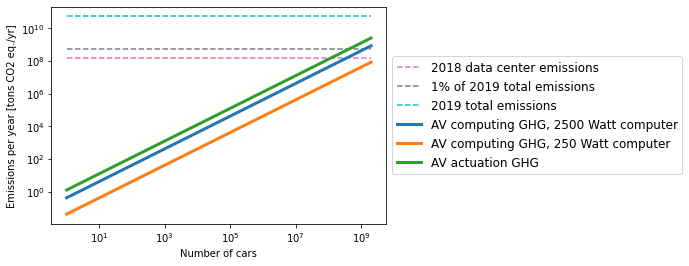

In [6]:
# sweeping number of AVs 
N = np.asarray([1, 1e2, 1e3, 1e6, 1e7, 1e8, 1e9, 2e9]) # number of autonomous cars
# calculate computing emissions
computing_ghg_1 = get_computing_emissions_n_cars(N,P_1,Q,I)
computing_ghg_2 = get_computing_emissions_n_cars(N,P_2,Q,I)
# calculate actuation emissions 
actuation_ghg = get_actuation_emissions_n_cars(N,M,Q,K,I)
# set baselines
current_ghg = 52.4*1e9 # tons
one_percent_current_ghg = 0.01*current_ghg # tons
datacenter_ghg = 0.14*1e9 # tons
# plotting baselines
plt.figure()
plt.plot(N, datacenter_ghg*np.ones(computing_ghg_1.shape), '--', label="2018 data center emissions", color = "C6")
plt.plot(N, one_percent_current_ghg*np.ones(computing_ghg_1.shape), '--', label = "1% of 2019 total emissions", color = graycolor)
plt.plot(N, current_ghg*np.ones(computing_ghg_1.shape), '--', label="2019 total emissions", color="C9")
## plot log-log plot of number of cars vs. emissions
plt.plot(N, computing_ghg_1, label="AV computing GHG, " + str(P_1) + " Watt computer", linewidth=3)
plt.plot(N, computing_ghg_2, label="AV computing GHG, " + str(P_2) + " Watt computer", linewidth=3)
plt.plot(N, actuation_ghg, label="AV actuation GHG", linewidth=3)
plt.yscale('log')
plt.xscale('log')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)
plt.xlabel("Number of cars")
plt.ylabel("Emissions per year [tons CO2 eq./yr]")
plt.show()

We compute the number of autonomous vehicles it would take under both scenarios to hit each baseline and the ratio of actuation to computing emissions. 

In [7]:
print("Scenario for computer power = " + str(P_1) + " Watts")
num_cars_intersection_one_percent_current_ghg = get_intersection_computing_emissions("N", one_percent_current_ghg, None, P_1,Q,I)
num_cars_intersection_datacenter_ghg = get_intersection_computing_emissions("N", datacenter_ghg, None,P_1,Q,I)
print("   " + str(round(num_cars_intersection_one_percent_current_ghg/1e6,1)) +" million autonomous vehicles for computing emissions to be equivalent to 1% of current GHG emissions")
print("   " + str(round(num_cars_intersection_datacenter_ghg/1e6,1)) + " million autonomous vehicles for computing emissions to be equivalent to datacenter GHG emissions")
print("   " + "Ratio of actuation emissions to computing emissions: " + str(round(actuation_ghg[0]/computing_ghg_1[0],1))+":1")
print("   " + "Computing energy consumes " + str(round(computing_ghg_1[0]/(computing_ghg_1[0]+actuation_ghg[0])*100,1)) + "% of total energy expenditure of the AV (computing + actuation)")

print("Scenario for computer power = " + str(P_2) + " Watts")
num_cars_intersection_one_percent_current_ghg = get_intersection_computing_emissions("N", one_percent_current_ghg, None, P_2,Q,I)
num_cars_intersection_datacenter_ghg = get_intersection_computing_emissions("N", datacenter_ghg, None,P_2,Q,I)
print("   " + str(round(num_cars_intersection_one_percent_current_ghg/1e6,1)) +" million autonomous vehicles for computing emissions to be equivalent to 1% of current GHG emissions")
print("   " + str(round(num_cars_intersection_datacenter_ghg/1e6,1)) + " million autonomous vehicles for computing emissions to be equivalent to datacenter GHG emissions")
print("   " + "Ratio of actuation emissions to computing emissions: " + str(round(actuation_ghg[0]/computing_ghg_2[0],1))+":1")
print("   " + "Computing energy consumes " + str(round(computing_ghg_2[0]/(computing_ghg_2[0]+actuation_ghg[0])*100,1)) + "% of total energy expenditure of the AV (computing + actuation)")

Scenario for computer power = 2500 Watts
   1253.8 million autonomous vehicles for computing emissions to be equivalent to 1% of current GHG emissions
   335.0 million autonomous vehicles for computing emissions to be equivalent to datacenter GHG emissions
   Ratio of actuation emissions to computing emissions: 3.0:1
   Computing energy consumes 25.0% of total energy expenditure of the AV (computing + actuation)
Scenario for computer power = 250 Watts
   12538.1 million autonomous vehicles for computing emissions to be equivalent to 1% of current GHG emissions
   3349.9 million autonomous vehicles for computing emissions to be equivalent to datacenter GHG emissions
   Ratio of actuation emissions to computing emissions: 30.0:1
   Computing energy consumes 3.2% of total energy expenditure of the AV (computing + actuation)


Next, we simulate various values of $N$ number of cars to model future scenarios where autonomous vehicles are a significant portion of the cars on the road. We sweep over possible computer power $P$ values, plot the emissions vs. computer power, and calculate the computer power at the intersections with the two baselines. 

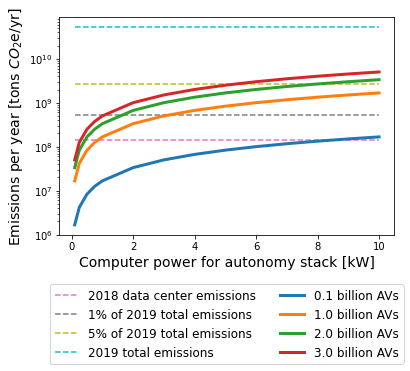

0.1 billion AVs: 
   Computer power P for 2018 data center emissions: 8.37 kW
   Computer power P for 1% of today's emissions: 31.35 kW
1.0 billion AVs: 
   Computer power P for 2018 data center emissions: 0.84 kW
   Computer power P for 1% of today's emissions: 3.13 kW
2.0 billion AVs: 
   Computer power P for 2018 data center emissions: 0.42 kW
   Computer power P for 1% of today's emissions: 1.57 kW
3.0 billion AVs: 
   Computer power P for 2018 data center emissions: 0.28 kW
   Computer power P for 1% of today's emissions: 1.04 kW


In [8]:
# initialize sweeping variables and containers
N_multiple = [1e8, 1e9, 2e9, 3e9] # number of cars
P_sweep = np.asarray([100,250,500,750,1000,2000,3000,4000,5000,6000,7000,8000,9000,10000]) # computer power [W]
computing_ghgs = []
actuation_ghgs = []

# calculate computing emissions
for n in N_multiple:
    computing_ghgs.append(get_computing_emissions_n_cars(n, P_sweep, Q, I))

# plotting baselines
plt.plot(P_sweep/1000.0, datacenter_ghg*np.ones(computing_ghgs[0].shape), '--', label="2018 data center emissions", color = "C6")
plt.plot(P_sweep/1000.0, one_percent_current_ghg*np.ones(computing_ghgs[0].shape), '--', label = "1% of 2019 total emissions", color = graycolor)
plt.plot(P_sweep/1000.0, 5*one_percent_current_ghg*np.ones(computing_ghgs[0].shape), '--', label = "5% of 2019 total emissions", color = "C8")
plt.plot(P_sweep/1000.0, current_ghg*np.ones(computing_ghgs[0].shape), '--', label="2019 total emissions", color = "C9")

# plot emissions for various scenarios
for i in range(len(N_multiple)):
    plt.plot(P_sweep/1000.0, computing_ghgs[i], label=str(N_multiple[i]/(1e9))+" billion AVs", linewidth=3)

plt.yscale('log')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2, fontsize=12)
plt.xlabel("Computer power for autonomy stack [kW]", fontsize=14)
plt.ylabel("Emissions per year [tons $CO_2$e/yr]", fontsize=14)

plt.show()
# compute intersections with baselines
for n in N_multiple:
    power_intersection_datacenter_ghg = get_intersection_computing_emissions("P", datacenter_ghg, n, None, Q, I)
    power_intersection_one_percent_current_ghg = get_intersection_computing_emissions("P", one_percent_current_ghg, n, None, Q, I)
    power_intersection_five_percent_current_ghg = get_intersection_computing_emissions("P", 5*one_percent_current_ghg, n, None, Q, I)
    print(str(n/1e9) + " billion AVs: ")
    print("   Computer power P for 2018 data center emissions: " + str(round(power_intersection_datacenter_ghg/1000,2)) + str(" kW"))
    print("   Computer power P for 1% of today's emissions: " + str(round(power_intersection_one_percent_current_ghg/1000,2)) + str(" kW"))


We see with only 100 million AVs on the road, emissions from computing onboard AVs can still exceed data center emissions if the onboard computers consume more than 8.4 kW. With one billion AVs, less than the number of cars today [A1], the computer power must be less than 0.84 kW to have computing onboard AVs contribute less emissions than data centers.

However, the values of the variables $N$, $P$, $Q$, and $I$ are not exactly known, and there is large uncertainty with respect to future trends that have the potential to reduce emissions. We next probabilistically model each variable in Eq.1 based on current trends and model different scenarios based on future trends. 

# 3. Surveyed current trends and future trends for framework

We survey the literature to estimate the parameters for probabilistic models of each of the variables in Eq. 1 for both current trends and future trends from 2025-2050. 

<!-- Modeling sensor rate ($F$)
To-do:

*   Stats on camera frame rates, Lidar frame rates, what's available from industry (e.g., Tesla), and likely higher frame rates for Level 4/5 \
36 Hz from Tesla (4:25 https://www.youtube.com/watch?v=3SypMvnQT_s&t=403s) \
60 Hz for system recently published by Waymo (Sun, Pei, Weiyue Wang, Yuning Chai, Gamaleldin Elsayed, Alex Bewley, Xiao Zhang, Cristian Sminchisescu, and Dragomir Anguelov. "Rsn: Range sparse net for efficient, accurate lidar 3d object detection." In Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition, pp. 5725-5734. 2021.)
*   Justify selection of parameters for $F \sim \mathcal{N(\mu_F, \sigma^2_F)}$ -->




## Modeling number of autonomous cars ($N$)
### Current trends

There were an estimated 1.2 billion
vehicles on the road in 2015 [A1]. Meanwhile, in 2019, there
were 1,400 AVs approved for testing in the US [A2]; clearly,
we are not at a point where AVs dominate the market. We
model N ∼ Binomial($1.2\times10^9$, $p_n$) for a range of adoption
rates $p_n$.




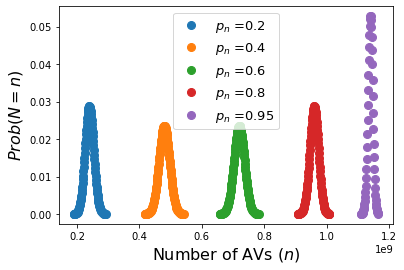

In [9]:
n_max_millions_of_cars =1.2*10**3 # current estimated millions of cars
p_ns = [0.2, 0.4, 0.6, 0.8, 0.95] # adoption rates p_n
fig, ax = plt.subplots(1, 1)
# plot distributions
for p_n in p_ns: 
    x = np.arange(binom.ppf(0.0001, n_max_millions_of_cars, p_n),
                  binom.ppf(0.9999, n_max_millions_of_cars, p_n))
    ax.plot(x*10**6, binom.pmf(x, n_max_millions_of_cars, p_n), 'o', ms=8, label="$p_n$ ="+ str(p_n))
plt.xlabel("Number of AVs ($n$)", fontsize=16)
plt.ylabel("$Prob(N = n)$", fontsize=16)
plt.legend(fontsize=13)
plt.show()

### Future trends
While Level 4-5 autonomous vehicles today are not widely adopted today, we consider scenarios with wide adoption of AVs since these are the relevant scenarios where there is an impact on emissions. For example, here we model two scenarios for $N_{2025−2050}$ assuming a 12 year lifespan for AVs, a projected 2.2% increase in vehicle sales each year [G1] with vehicle sales returning to 2019 sales by 2025 [G4], and an approximation of a high adoption projection [G3] where AVs capture 95% of the market share by 2050 or a medium adoption projection where AVs capture 95% of the market share by 2075.

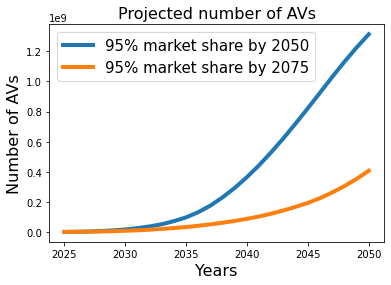

In [10]:
def project_number_AVs_over_time(years, percent_AV_market_share, number_cars_sold_year_1, number_cars_sold_annual_growth, car_lifetime):
    number_cars_sold = np.zeros(years.shape) # initialize empty container
    number_cars_sold[0] = number_cars_sold_year_1 # 2025 starting sales
    # compute number of cars sold each year
    for i in range(1,years.shape[0]):
        number_cars_sold[i] = number_cars_sold[i-1]*number_cars_sold_annual_growth
    # compute number of AVs sold each year
    number_AVs_sold_per_year = percent_AV_market_share*number_cars_sold
    # compute total number of AVs on the road including retiring car after lifetime for each year 
    total_AVs_sold_until_car_lifetime = np.zeros(years.shape) # initialize container
    for i in range(years.shape[0]):
        if i < car_lifetime: # no cars retired yet, count AVs sold in all years until now
            for j in range(i+1):
                total_AVs_sold_until_car_lifetime[i] += number_AVs_sold_per_year[j]
        else: # only count AVs sold in window of car lifetime 
            for j in range(i+1-car_lifetime,i+1):
                total_AVs_sold_until_car_lifetime[i] += number_AVs_sold_per_year[j]
    return total_AVs_sold_until_car_lifetime, number_AVs_sold_per_year

number_cars_sold_year_1 = 88000000 # number of all cars sold in starting year
number_cars_sold_annual_growth = 1.022 # annual percent growth in car sales
car_lifetime = 12 # lifetime of a car
# scenario 1: 95% market share by 2050
years = np.arange(2025,2051,1) 
percent_AV_market_share = np.asarray([1,1,2,3,5,6,9,11,14,19,23,31,39,48,54,61,67,73,78,82,85,89,91,93,94,95])*0.01 
projected_AVs_market_share_95_at_2050, projected_sales_per_year_market_share_95_at_2050 = project_number_AVs_over_time(years, percent_AV_market_share, number_cars_sold_year_1, number_cars_sold_annual_growth, car_lifetime)
# scenario 2: 95% market share by 2075
num_years_original = np.shape(percent_AV_market_share)[0]
years_x = np.arange(0, 2*num_years_original, 2)
years_x_new = np.arange(2*num_years_original-1)     
percent_AV_market_share_95_at_2075 = np.interp(years_x_new, years_x, percent_AV_market_share) 
projected_AVs_market_share_95_at_2075, projected_sales_per_year_market_share_95_at_2075 = project_number_AVs_over_time(years, percent_AV_market_share_95_at_2075[:26], number_cars_sold_year_1, number_cars_sold_annual_growth, car_lifetime)
# plot scenarios
plt.plot(years,projected_AVs_market_share_95_at_2050, label="95% market share by 2050",linewidth=4)
plt.plot(years,projected_AVs_market_share_95_at_2075, label="95% market share by 2075",linewidth=4)
plt.title("Projected number of AVs", fontsize=16)
plt.xlabel("Years", fontsize=16)
plt.ylabel("Number of AVs", fontsize=16)
plt.legend(fontsize=15)
plt.show()

## Modeling computer power ($P$)
### Current trends
We choose to model only the DNN portion workload which likely plays a substantial role in the autonomy stack.
In order to model the power of the autonomy stack running DNN inference for $T$ tasks at $F$ Hz throughput for $C$ cameras on a target computing hardware platform given a measured power and latency for $T$ tasks on a single image on a measured computing hardware platform, we use 
\begin{equation}
    P_{target} = P_{meas}(T)l_{meas}(T)\eta F C.
    \label{eq:P_2}
\end{equation}
such that plugging in $P_{target}$ for $P$ to calculate emissions $G$ results in
\begin{equation}
G = \alpha NP_{meas}(T)l_{meas}(T)\eta F CQI
\end{equation}
where $P_{target}$ is the extrapolated power on the target hardware platform, $P_{meas}(T)$ is the measured power on the measured hardware platform and is a function of the number of tasks $T$, $l_{meas}(T)$ is the measured latency on the measured hardware platform and is a function of the number of tasks $T$, $\eta$ is the ratio of the tera operations per second (TOPS) per Watt of the measured hardware and the TOPS per Watt of the target hardware, $F$ is the target throughput in Hz of the autonomy stack, and $C$ is the number of cameras in the autonomy stack. 

Consider that $l_{meas}(T)\eta$ is the simulated latency on the target platform, $\frac{l_{meas}(T)\eta}{1/F} = l_{meas}(T)\eta F$ is the effective number of simulated target platforms needed to hit the desired throughput $F$ for a single camera, and $l_{meas}(T)\eta F C$ is the effective number of simulated target platforms needed to hit the desired throughput $F$ for multiple cameras. 
We benchmark $P_{meas}(T)$ and $l_{meas}(T)$ using a multitask DNN architecture with a shared encoder and separate decoders for each task based on its popularity in academia and industry [C3, C4]. We use EfficientNet-B0 as the encoder [C5] and DeepLabV3 heads as the decoders [C6]. We consider the number of tasks $T$ to be the number of decoders on the autoencoder and the number of cameras C to be the number of times we run the autoencoder. 

We plot various example distributions for $T$, $F$, and $C$. 

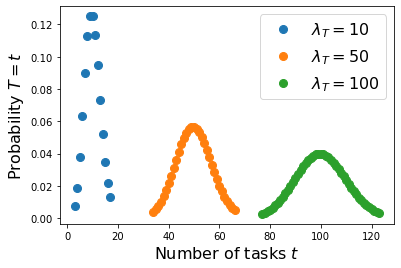

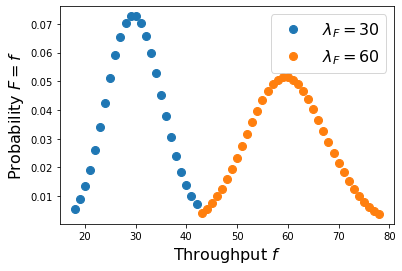

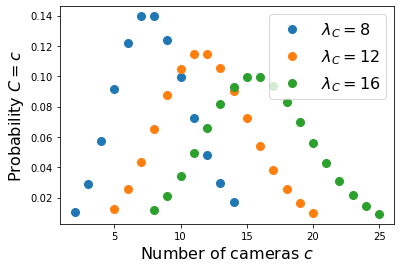

In [11]:
# number of tasks
mu_Ts = [10, 50, 100]
plt.figure()
for mu_T in mu_Ts:
    x_T = np.arange(poisson.ppf(0.01, mu_T),
                  poisson.ppf(0.99, mu_T))
    plt.plot(x_T, poisson.pmf(x_T, mu_T), 'o', ms=8, label="$\lambda_T = $" + str(mu_T))
    plt.xlabel("Number of tasks $t$", fontsize=16)
    plt.ylabel("Probability $T=t$", fontsize=16)
plt.legend(fontsize=16)
plt.show()
# throughput
mu_Fs = [30, 60]
plt.figure()
for mu_F in mu_Fs:
    x_F = np.arange(poisson.ppf(0.01, mu_F),
                  poisson.ppf(0.99, mu_F))
    plt.plot(x_F, poisson.pmf(x_F, mu_F), 'o', ms=8, label="$\lambda_F = $" + str(mu_F))
    plt.xlabel("Throughput $f$", fontsize=16)
    plt.ylabel("Probability $F=f$", fontsize=16)
plt.legend(fontsize=16)
plt.show()
# number of cameras
mu_Cs = [8, 12, 16]
plt.figure()
for mu_C in mu_Cs:
    x_C = np.arange(poisson.ppf(0.01, mu_C),
                  poisson.ppf(0.99, mu_C))
    plt.plot(x_C, poisson.pmf(x_C, mu_C), 'o', ms=8, label="$\lambda_C = $" + str(mu_C))
    plt.xlabel("Number of cameras $c$", fontsize=16)
    plt.ylabel("Probability $C=c$", fontsize=16)
plt.legend(fontsize=16)
plt.show()

While TOPS per Watt is known to not be a holistic measure [D1], we use it as an approximation to scale hardware energy efficiency since it is expensive and difficult to get access to state-of-the-art or not yet in production AV computing hardware. We measure the power $P_{meas}(T)$ and latency $l_{meas}(T)$ of the autoencoder at various values of $T$ for 1344 × 1344 resolution inputs, a resolution close to that found in AV benchmarks [C15, C16] on a Nvidia RTX 2080 Ti and scale the hardware energy efficiency with the target TOPS (INT8)/Watt of a Nvidia Drive Orin to compute $\eta$. 

In [12]:
# read in as pandas dataframe measured power and latency on measured hardware platform
meas_data_filepath = "./multitask_networks_b0_all_task_nums_benchmark.csv"
df_meas = pd.read_csv(meas_data_filepath) # read in dataframe

In [13]:
# get measured latency and power for given number of tasks and resolution from dataframe
def meas_latency_power(df, num_tasks, resolution):
    dnn_lat = df[(df["resolution"] == resolution) & (df["num_tasks"] == num_tasks)]["latency_avg"]
    dnn_pow = df[(df["resolution"] == resolution) & (df["num_tasks"] == num_tasks)]["power"]
    return dnn_lat, dnn_pow

# compute simulated power for a given number of tasks, number of cameras, throughput, hardware energy efficiency, 
# measured power, and measured latency
def get_simulated_power(T,C,F,eta,df_meas,max_sim_computer_power,A=1):
    l_meas, P_meas = meas_latency_power(df_meas, int(T), resolution=1344) 
    P_sim = min(max_sim_computer_power, float(P_meas*l_meas*eta*F*C*A))
    return P_sim

# compute emissions for a given number of cars, number of tasks, number of cameras, throughput, hardware energy efficiency, 
# measured power, and measured latency
def get_computing_emissions_n_cars_modeled_workload(N,Q,I,T,C,F,eta,df_meas,max_sim_computer_power=np.inf,batt_eff=1):
    P_target = get_simulated_power(T,C,F,eta,df_meas,max_sim_computer_power)
    return float(N*(get_computing_emissions_single_car(P_target,Q,I,batt_eff)))


### Future trends
To model how $\eta$ will change over time, we model the rate of increase in TOPS per Watt of AV hardware. Based on
historical patterns until 2009, Koomey’s law states that TOPS per Watt doubles on average approximately every 1.6 years [H1]. However, the slowdown of Dennard scaling and Moore’s law has made
keeping up with this rate of improvement challenging [H2].
We plot the natural log of the reported TOPS per Watt
for current and announced AV hardware platforms and their
production dates in Fig. 2. We fit a linear model to find the average doubling rate of TOPS per Watt for AV hardware
to be 2.8 years. We model $\eta_{2025−2050}$ at various rates of
hardware energy efficiency doubling including at the current
pace.

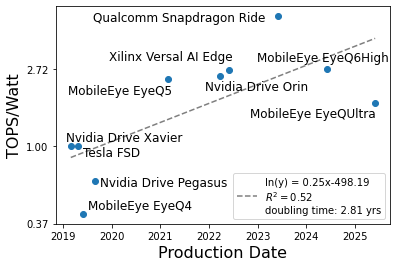

In [14]:
# compute fractional year
def get_year_fraction(date):
    year = date.year
    first_day_year = datetime(year=year, month=1, day=1)
    fraction_year_seconds = time.mktime(date.timetuple()) - time.mktime(first_day_year.timetuple())
    if (year % 4) != 0: # not a leap year
        seconds_in_year = 365*24*3600  
    else: # leap year
        seconds_in_year = 366*24*3600  
    fraction = fraction_year_seconds/seconds_in_year
    return date.year + fraction

# production dates and TOPS per Watt for surveyed AV hardware platforms
hardware_names = ["Nvidia Drive Xavier", "Nvidia Drive Pegasus", "Nvidia Drive Orin", "Tesla FSD", "Xilinx Versal AI Edge", "MobileEye EyeQUltra", "MobileEye EyeQ6High","MobileEye EyeQ4","MobileEye EyeQ5", "Qualcomm Snapdragon Ride"]
TOPS = np.asarray([30,320,2000,72,202,176, 34, 2.5, 24, 700])
Watts = np.asarray([30,500,800,72,75,100,12.5,6,10,130])
TOPS_per_Watt = TOPS/Watts
production_dates = [date(2019, 3, 1), date(2019, 9, 1), date(2022, 3, 22), date(2019, 4, 22), date(2022, 6, 1), date(2025, 6, 1), date(2024, 6,1), date(2019,6,1), date(2021,3,1), date(2023,6,1)] 
# convert production date time format to fractional year
production_years = []
for d in production_dates:
    production_years.append(get_year_fraction(d))
production_years = np.asarray(production_years)
# plot natural log plot 
fig, ax = plt.subplots()
ax.scatter(production_years, TOPS_per_Watt)
ax.set_yscale('log', base = math.e) # natural log
from matplotlib.ticker import ScalarFormatter
for axis in [ax.yaxis]:
    axis.set_major_formatter(ScalarFormatter())
plt.xlabel("Production Date", fontsize=16)
plt.ylabel("TOPS/Watt", fontsize=16) # $Log_{10}$
# location of text offset
offset = [(-5,5),(5,-5),(-15,-15), (5,-10), (-120,10),(-125,-15), (-70,8), (5,5), (-100,-15), (-185,-5)]
for i, name in enumerate(hardware_names):
    ax.annotate(name, (production_years[i], TOPS_per_Watt[i]), textcoords = 'offset pixels', xytext=offset[i], fontsize=12)
# linear regression on ln(TOPS/Watt) to find doubling years 
log_TOPS_per_Watt = np.log(TOPS_per_Watt)
reg = LinearRegression().fit(production_years.reshape(-1,1), log_TOPS_per_Watt)
historical_TOPS_per_Watt_doubling_years = float(np.log(2)/reg.coef_) 
log_TOPS_per_Watt_pred = reg.predict(production_years.reshape(-1,1))
r2 = sklearn.metrics.r2_score(log_TOPS_per_Watt, log_TOPS_per_Watt_pred)
x_pred_plotting = np.array((np.amin(production_years), np.amax(production_years))).reshape(-1,1)
log_TOPS_per_Watt_pred_plotting = reg.predict(x_pred_plotting)
# plot regression line
plt.plot(x_pred_plotting, np.exp(log_TOPS_per_Watt_pred_plotting), '--', color=graycolor, label="ln(y) = "+str(round(float(reg.coef_),2))+"x"+str(round(reg.intercept_,2))+"\n$R^2=$"+str(round(r2,2))+"\ndoubling time: "+ str(round(historical_TOPS_per_Watt_doubling_years,2))+" yrs")
plt.legend(loc="lower right")
plt.show()

In [15]:
# project hardware energy efficiency ratio given half-life
def project_hardware_efficiency_ratio(years, half_life, start_ratio):
    hardware_efficiency_ratio_eta = np.ones(years.shape)*start_ratio
    annual_decay_rate = np.log(2)/half_life
    for i in range(1,years.shape[0]):
        hardware_efficiency_ratio_eta[i]=hardware_efficiency_ratio_eta[i-1]*(1-annual_decay_rate)
    return hardware_efficiency_ratio_eta

# project exponential growth for a variable given doubling years
def project_exponential_growth(years, doubling_years, start_year_quantity):
    projected_quantity = np.ones(years.shape)*start_year_quantity
    annual_growth_rate = np.log(2)/doubling_years
    for i in range(1,years.shape[0]):
        projected_quantity[i]=projected_quantity[i-1]*(1+annual_growth_rate)
    return projected_quantity

# compute emissions for a given number of cars, number of tasks, number of cameras, throughput, hardware energy efficiency, 
# measured power, measured latency, and workload scaled by a factor of A 
def get_computing_emissions_n_cars_modeled_workload_scale_architecture(N,Q,I,A,C,F,eta,df_meas,T,max_sim_computer_power,batt_eff = 1):
    P_target = get_simulated_power(T,C,F,eta,df_meas,max_sim_computer_power,A)
    return float(N*(get_computing_emissions_single_car(P_target,Q,I,batt_eff)))

## Modeling time driven ($Q$)
### Current trends
We use data from the 2017 National Household Travel Survey (NHTS) [E1] to find the average hours American vehicles were driven per day. 

In [16]:
# download NHTS data -- only run if first time running notebook

# !mkdir nhts_2017_data
# !wget -P ./nhts_2017_data https://nhts.ornl.gov/assets/2016/download/csv.zip
# !unzip ./nhts_2017_data/csv.zip -d ./nhts_2017_data/


In [17]:
# read in csv as pandas dataframe 
df = pd.read_csv("./nhts_2017_data/trippub.csv")
df_household = pd.read_csv("./nhts_2017_data/hhpub.csv")

In [18]:
# compute total number of cars in the survey (HHVEHCNT = Count of household vehicles)
total_num_cars = df_household["HHVEHCNT"].sum() 
# compute sample mean and variance of average minutes traveled per day 
# only look at passenger cars and respondent is actual driver 
df_passenger_cars = df[((df["TRPTRANS"] >=3) & (df["TRPTRANS"] <= 6) | (df["TRPTRANS"] == 17) | (df["TRPTRANS"] == 18)) & (df["DRVR_FLG"] == 1)]
# group by house id and vehicle id, calculate cumulative trip time for that day
df_passenger_cars = df_passenger_cars.groupby(['HOUSEID','VEHID']).sum()
# remove data that has negative values for travel time 
df_passenger_cars = df_passenger_cars[df_passenger_cars["TRVLCMIN"] >= 0]
# compute number of cars that drove that day
num_cars_that_day = len(df_passenger_cars)
# compute mean and standard deviation
total_hrs_driven_per_day = (df_passenger_cars["TRVLCMIN"]/60.0).sum()
mean_hrs_driven_per_day = (df_passenger_cars["TRVLCMIN"]/60.0).mean()
std_dev_hrs_driven_per_day = (df_passenger_cars["TRVLCMIN"]/60.0).std()
print("Total number of cars in the survey: " + str(total_num_cars))
print("Number of cars driving that day: " + str(num_cars_that_day))
print("Total hours driven: " + str(round(total_hrs_driven_per_day,2)))
print("Average hours driven by all cars: " + str(round(total_hrs_driven_per_day/total_num_cars,2)))
print("Average hours driven by only cars that drove that day: " + str(round(mean_hrs_driven_per_day,2)))
print("Median hours driven by only cars that drove that day: " + str((df_passenger_cars["TRVLCMIN"]/60.0).median()))
print("Std. deviation hours driven by only cars that drove that day: " + str(round(std_dev_hrs_driven_per_day,2)))

Total number of cars in the survey: 256115
Number of cars driving that day: 155482
Total hours driven: 203037.67
Average hours driven by all cars: 0.79
Average hours driven by only cars that drove that day: 1.31
Median hours driven by only cars that drove that day: 1.0
Std. deviation hours driven by only cars that drove that day: 1.18


There is uncertainty in how driving behavior may change in response to the widespread adoption of AVs. Projections for changes range from -35% to 40% [E2] due to an increase in driving due to multitasking [E3] and expansion of the transportation user-base to individuals who currently face limited mobility, or a decrease in driving due to increased car-sharing [E2, E4, E5]. We represent the range of -40% to 40% as a 95% confidence interval to obtain a standard deviation of 0.16 and Q ∼ N (0.79, 0.03).


In [19]:
# helper function to plot normal distribution 
def plot_normal_distribution(mean, std_dev, num_std_dev, x_label, y_label):
    x_norm = np.linspace(mean - num_std_dev*std_dev, mean + num_std_dev*std_dev, 100)
    plt.figure()
    plt.plot(x_norm, stats.norm.pdf(x_norm, mean, std_dev),linewidth=4)
    plt.xlabel(x_label, fontsize=16)
    plt.ylabel(y_label, fontsize=16)

Standard deviation of normal distribution: 0.162
Variance of normal distribution: 0.026


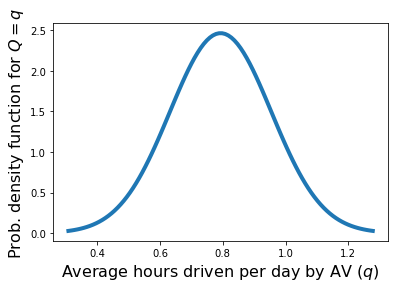

In [20]:
# plot distribution for total hours driven per day
avg_hrs_all_cars = total_hrs_driven_per_day/total_num_cars
CI_half_interval = 0.4*avg_hrs_all_cars # CI (confidence interval) 
std_dev_mean_hrs_driven = (CI_half_interval)/1.96
print("Standard deviation of normal distribution: " + str(round(std_dev_mean_hrs_driven,3)))
print("Variance of normal distribution: " + str(round(std_dev_mean_hrs_driven**2,3)))
plot_normal_distribution(avg_hrs_all_cars, std_dev_mean_hrs_driven, 3, "Average hours driven per day by AV ($q$)", "Prob. density function for $Q = q$")

## Modeling carbon intensity ($P$)
### Current trends
Carbon intensity, or the $CO_2$e grams released per kWh of energy generated, varies from approximately 10 g $CO_2$e/kWh for wind energy to 50 g $CO_2$e/kWh for solar photovoltaics [F1] to over 950 g $CO_2$e/kWh for gasoline and coal [F2], resulting in differences geographically in the carbon intensity of the electric grid based on each region's mix of fossil fuels and renewable energy to generate electricity used to power the computers onboard AVs. We use the global average carbon intensity of electricity generation to capture the average carbon intensity across all AVs. Due to changes in economic activity due to the COVID-19 pandemic, we use the average global carbon intensity estimate for 2019, select a variance that captures differences in carbon intensity estimates between years [F4], and set $I \sim \mathcal{N}(471, 25)$. 

Note, if we assume only fossil-fuel energy such as a gasoline powered vehicle, the carbon intensity would be much higher at over 1,100 g $CO_2$e/kWh for gasoline [F2], resulting in much higher emissions from computing.

Global average carbon intensity: 471.2
Std. dev of global average carbon intensity: 5


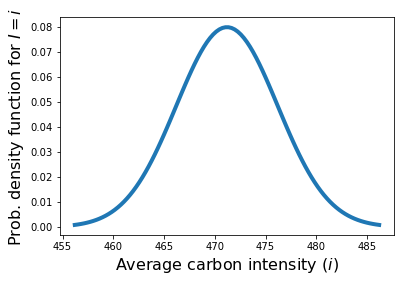

In [21]:
# plot carbon intensity distribution
carbon_intensity_mean = 471.2 
carbon_intensity_std_dev = 5 
print("Global average carbon intensity: " + str(carbon_intensity_mean))
print("Std. dev of global average carbon intensity: " + str(carbon_intensity_std_dev))
plot_normal_distribution(carbon_intensity_mean, carbon_intensity_std_dev, 3, "Average carbon intensity ($i$)", "Prob. density function for $I = i$")

### Future trends
Decarbonization reduces the carbon intensity of the electricity used to power the computer and will directly reduce emissions from computing. We model four different scenarios for carbon intensity $I_{2025-2050}$ using different annual decarbonization rates from 471 g $CO_2$e/kWh: 1) 1.5\% (business as usual, 2019 rate), 2) 2.5\% (2020), 3) 8.1\% (consistent with 2 degrees of warming), 4) 12.9\% (consistent with 1.5 degrees of warming)~[K1].


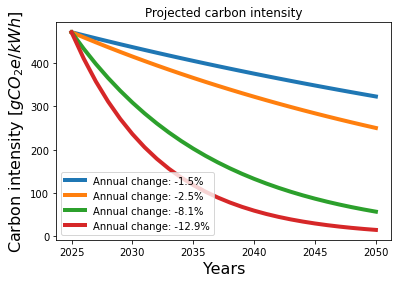

In [22]:
# project carbon intensity with annual decarbonization rate
def project_carbon_intensity(years, start_CI, annual_change):
    projected_carbon_intensity = np.zeros(years.shape)
    projected_carbon_intensity[0] = start_CI
    for i in range(1,years.shape[0]):
        projected_carbon_intensity[i]=projected_carbon_intensity[i-1]*(1+annual_change)
    return projected_carbon_intensity

# plot example scenarios of carbon intensity decarbonization 
projected_carbon_intensity_business_as_usual = project_carbon_intensity(years, carbon_intensity_mean, -0.015)
projected_carbon_intensity_2020 = project_carbon_intensity(years, carbon_intensity_mean, -0.025)
projected_carbon_intensity_2_deg = project_carbon_intensity(years, carbon_intensity_mean, -0.081)
projected_carbon_intensity_1_5_deg = project_carbon_intensity(years, carbon_intensity_mean, -0.129)
plt.plot(years,projected_carbon_intensity_business_as_usual, label="Annual change: " + str(100*-0.015)+ "%", linewidth=4)
plt.plot(years,projected_carbon_intensity_2020, label="Annual change: " + str(100*(-0.025))+ "%", linewidth=4)
plt.plot(years,projected_carbon_intensity_2_deg, label="Annual change: " + str(100*(-0.081))+ "%", linewidth=4)
plt.plot(years,projected_carbon_intensity_1_5_deg, label="Annual change: " + str(100*(-0.129))+ "%", linewidth=4)
plt.title("Projected carbon intensity")
plt.xlabel("Years", fontsize=16)
plt.ylabel("Carbon intensity $[g CO_2e/kWh]$", fontsize=16)
plt.legend()
plt.show()


# 4. Scenarios Using Current Trends

Based on the discussion above, we now have distributions to model each of the variables in 
\begin{equation}
G = \alpha NP_{meas}(T)l_{meas}(T)\eta F CQI.
\end{equation}
Since there is no closed-form solution to solve for $G$ directly, we draw samples from each variable's distribution one million times to compute the probability of staying under the emissions baselines. Note, modeling 1 million scenarios takes close to 30 minutes on an Intel(R) Xeon(R) CPU E3-1505M v5 @ 2.80GHz, so we set the number of scenarios to be 1,000 for quicker results in this notebook. This can be changed by setting `num_samples` to the desired number


In [23]:
# Parameters for N ~ Binom(n_max, p_n)
n_max = int(n_max_millions_of_cars)
# Parameters for Q ~ Gaussian(mu_Q, sigma_Q)
mu_Q = avg_hrs_all_cars # hrs per day
sigma_Q = std_dev_mean_hrs_driven # mean_hrs_driven_norm_scale_fit # hrs per day
# Parameters for I ~ Gaussian(mu_I, sigma_I)
mu_I = carbon_intensity_mean # avg carbon intensity
sigma_I = carbon_intensity_std_dev 
# Parameters for T ~ Pois(mu_T)
mu_T = 10
# Parameters for C ~ Pois(mu_C)
mu_C = 8
# Parameters for F ~ Pois(mu_F)
mu_F = 60 # frame per second sensor(s) are run

# read in measured dataframe 
data_filepath = "./multitask_networks_b0_all_task_nums_benchmark.csv"
df_meas = pd.read_csv(data_filepath) # read in pandas dataframe

# starting hardware efficiency ratio
TOPS_per_Watt_comp_1 = 215.2/250 # TOPS (INT8)/W Nvidia RTX 2080 Ti
TOPS_per_Watt_comp_2 = 2000/800 # TOPS (INT8)/W Nvidia Drive Orin
eta = TOPS_per_Watt_comp_1/TOPS_per_Watt_comp_2

# number of samples for simulations
num_samples = int(1e3) #int(1e6)

Here, we write some helper functions that sample from distributions and compute the empirical cdf and inverse empirical cdf.

In [24]:
def sample_gaussian(mean,std_dev,num_samples):
    samples = np.random.normal(mean,std_dev,num_samples)
    return samples # np array

def sample_binomial(n,p,num_samples):
    samples = binom.rvs(n, p, size=num_samples)
    return samples

def sample_positive_poisson(mu, num_samples):
    samples = 0
    # don't sample 0
    while samples == 0: # works for num_samples = 1
        samples = poisson.rvs(mu, size=num_samples)
    return samples 

def empirical_cdf(data):
    data_sorted = np.sort(np.squeeze(data))
    cdf = np.arange(len(data_sorted))/float(len(data_sorted))
    return data_sorted, cdf

def compute_inv_empirical_cdf(data, probability):
    data_sorted = np.sort(np.squeeze(data))
    return data_sorted[int(len(data_sorted) * probability)]


We first vary the adoption rate of AVs and compute emissions in the various scenarios. 



In [25]:
# sweep over multiple adoption rates p_n for N ~ Binom(n_max, p_n)
p_n_adoption_rates = [0.2,0.4,0.6,0.8,0.95]
G_cs_varying_adoption_rate = [] # initialize container
for p_n_single in p_n_adoption_rates:
    G_c = [] # initialize storage containers 
    for i in tqdm(range(num_samples)):
        # sample from each variable's distribution
        N = sample_binomial(n_max, p_n_single, 1)*10**6
        Q = sample_gaussian(mu_Q, sigma_Q, 1) 
        I = sample_gaussian(mu_I, sigma_I, 1)
        T = sample_positive_poisson(mu_T,1) 
        C = sample_positive_poisson(mu_C,1) 
        F = sample_positive_poisson(mu_F,1)  
        # compute emissions for this sampled scenario
        G_c.append(get_computing_emissions_n_cars_modeled_workload(N,Q,I,T,C,F,eta,df_meas))
    G_cs_varying_adoption_rate.append(G_c) # save to plot later 

100%|████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 601.60it/s]


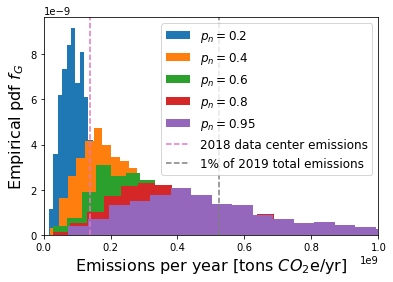

In [26]:
# plot figure 
plt.figure()
for i in range(len(p_n_adoption_rates)):
    n,x,_ = plt.hist(np.asarray(G_cs_varying_adoption_rate[i]), bins = "auto", density = True, histtype='stepfilled',label="$p_n = $" + str(p_n_adoption_rates[i]), linewidth=2)
plt.xlabel("Emissions per year [tons $CO_2$e/yr]")
# add vertical lines for baselines 
plt.axvline(x=datacenter_ghg, linestyle='--', color="C6", label = "2018 data center emissions")
plt.axvline(x=one_percent_current_ghg, linestyle='--', color=graycolor, label = "1% of 2019 total emissions")
plt.legend(fontsize=12)
plt.xlabel("Emissions per year [tons $CO_2$e/yr]", fontsize=16)
plt.ylabel("Empirical pdf $f_G$", fontsize=16)
plt.xlim([0,1*10**9])
plt.show()


Now, we vary between three different workloads, increasing in size: 1) 8 cameras, 10 tasks, 60 Hz, 2) 12 cameras, 50 tasks, 60 Hz, 3) 16 cameras, 100 tasks, 60 Hz.

In [27]:
# sweep over multiple mean number of cameras and tasks for C ~ Pois(mu_C) and T ~ Pois(mu_T)
mu_Cs = [8,12,16]
mu_Ts = [10,50,100]
G_cs_varying_workload = [] # initialize container
for j in range(3):
    G_c = [] # initialize storage containers 
    for i in tqdm(range(num_samples)):
        # sample from each variable's distribution
        N = sample_binomial(n_max, p_n, 1)*10**6
        Q = sample_gaussian(mu_Q, sigma_Q, 1) 
        I = sample_gaussian(mu_I, sigma_I, 1)
        T = sample_positive_poisson(mu_Ts[j],1) 
        C = sample_positive_poisson(mu_Cs[j],1) 
        F = sample_positive_poisson(mu_F,1)  
        # compute emissions for this sampled scenario
        G_N = get_computing_emissions_n_cars_modeled_workload(N,Q,I,T,C,F,eta,df_meas)
        G_c.append(G_N)
    G_cs_varying_workload.append(G_c) # save to plot later 

100%|████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 593.29it/s]


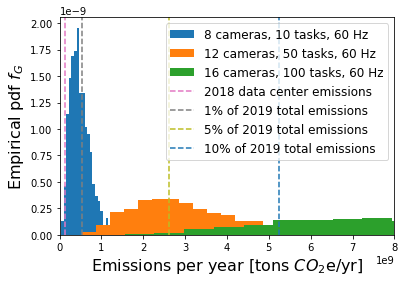

In [28]:
# plot figure
plt.figure()
for i in range(3):
    if i == 0:
        label = "8 cameras, 10 tasks, 60 Hz"
    elif i == 1:
        label = "12 cameras, 50 tasks, 60 Hz"
    elif i == 2:
        label = "16 cameras, 100 tasks, 60 Hz"
    n,x,_ = plt.hist(np.asarray(G_cs_varying_workload[i]), bins = "auto", density = True, histtype='stepfilled',label=label, linewidth=2)
plt.xlabel("Emissions per year [tons $CO_2$e/yr]")
# add vertical lines for baselines 
plt.axvline(x=datacenter_ghg, linestyle='--', color="C6", label = "2018 data center emissions")
plt.axvline(x=one_percent_current_ghg, linestyle='--', color=graycolor, label = "1% of 2019 total emissions")
plt.axvline(x=5*one_percent_current_ghg, linestyle='--', color="C8", label = "5% of 2019 total emissions")
plt.axvline(x=10*one_percent_current_ghg, linestyle='--', color=bluecolor, label = "10% of 2019 total emissions")
plt.legend(fontsize=12)
plt.xlabel("Emissions per year [tons $CO_2$e/yr]", fontsize=16)
plt.ylabel("Empirical pdf $f_G$", fontsize=16)
plt.xlim([0,0.8*10**10])
plt.show()


Next, assuming scenarios where emissions from computing on AVs are either equal to 2018 data center emissions or 1% of 2019 total emissions, we calculate the probability distribution of the computer power.

In [29]:
# sweep over multiple adoption rates p_n for N ~ Binom(n_max, p_n)
p_n_adoption_rates = [0.2,0.4,0.6,0.8,0.95]
# initialize containers
P_intersection_one_percent_current_ghg_varying_adoption_rate = []
P_intersection_datacenter_ghg_varying_adoption_rate = []
for p_n_single in p_n_adoption_rates:
    # initialize containers 
    P_intersection_one_percent_current_ghg = []
    P_intersection_datacenter_ghg = []
    for i in tqdm(range(num_samples)):
        # sample from each variable's distribution
        N = sample_binomial(n_max, p_n_single, 1)*10**6
        Q = sample_gaussian(mu_Q, sigma_Q, 1) 
        I = sample_gaussian(mu_I, sigma_I, 1)
        # calculate intersection of emissions baseline and power for this scenario 
        P_intersection_one_percent_current_ghg_scenario = get_intersection_computing_emissions("P", one_percent_current_ghg,N,None,Q,I)
        P_intersection_datacenter_ghg_scenario = get_intersection_computing_emissions("P", datacenter_ghg,N,None,Q,I)
        # store intersection
        P_intersection_one_percent_current_ghg.append(P_intersection_one_percent_current_ghg_scenario)
        P_intersection_datacenter_ghg.append(P_intersection_datacenter_ghg_scenario)
    P_intersection_one_percent_current_ghg_varying_adoption_rate.append(P_intersection_one_percent_current_ghg)
    P_intersection_datacenter_ghg_varying_adoption_rate.append(P_intersection_datacenter_ghg)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 11183.08it/s]


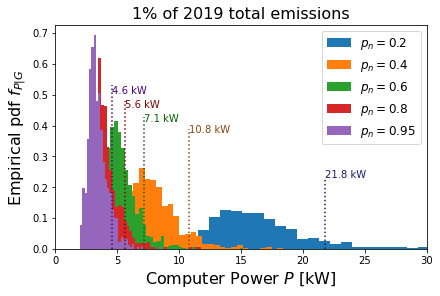

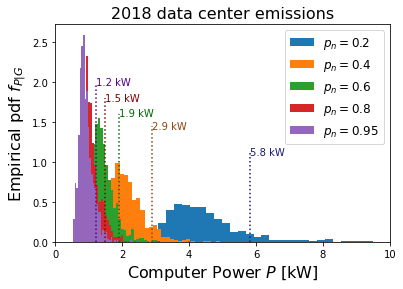

In [30]:
# plot figures
fig, ax = plt.subplots(1, 1, constrained_layout=True)
# heights of annotations for 90% inv. cdf 
y_max = [0.04/0.65+0.25, 0.07/0.65+0.425, 0.09/0.65+0.45, 0.12/0.65+0.475, 0.23+0.5] 
color_percentile = ["midnightblue","saddlebrown","darkgreen","maroon","indigo"]
for i in range(len(p_n_adoption_rates)):
    n,x,_ = plt.hist(np.asarray(P_intersection_one_percent_current_ghg_varying_adoption_rate[i])/1000.0, bins = "auto", density = True, histtype='bar',align='left', label="$p_n = $" + str(p_n_adoption_rates[i]), linewidth=2)
    # fill in up to 90 percent confidence and drop a line with label 
    P_star_one_percent_current_ghg_upper_bound = compute_inv_empirical_cdf(P_intersection_one_percent_current_ghg_varying_adoption_rate[i], 0.90) 
    plt.axvline(x=P_star_one_percent_current_ghg_upper_bound/1000.0, ymax=y_max[i],linestyle=':', color=color_percentile[i])
    plt.annotate(text = str(round(P_star_one_percent_current_ghg_upper_bound/1000.0,1))+" kW", xy=(P_star_one_percent_current_ghg_upper_bound/1000.0,y_max[i]*0.65+0.03),color=color_percentile[i])
plt.title("1% of 2019 total emissions", fontsize=16)
plt.legend(loc='upper right', fontsize=12)
plt.xlabel("Computer Power $P$ [kW]", fontsize=16)
plt.ylabel("Empirical pdf $f_{P|G}$", fontsize=16) 
plt.xlim([0,30])
plt.show()

# heights of annotations for 90% inv. cdf 
y_max = [0.04/0.65+0.35, 0.07/0.65+0.425, 0.09/0.65+0.45, 0.12/0.65+0.475, 0.23+0.5] 
for i in range(len(p_n_adoption_rates)):
    n,x,_ = plt.hist(np.asarray(P_intersection_datacenter_ghg_varying_adoption_rate[i])/1000.0, bins = "auto", density = True, histtype='bar',align='left', label="$p_n = $" + str(p_n_adoption_rates[i]), linewidth=2)
    # fill in up to 90 percent confidence and drop a line with label 
    P_star_datacenter_ghg_upper_bound = compute_inv_empirical_cdf(P_intersection_datacenter_ghg_varying_adoption_rate[i], 0.90)
    plt.axvline(x=P_star_datacenter_ghg_upper_bound/1000.0, ymax=y_max[i],linestyle=':', color=color_percentile[i])
    plt.annotate(text = str(round(P_star_datacenter_ghg_upper_bound/1000.0,1))+" kW", xy=(P_star_datacenter_ghg_upper_bound/1000.0,y_max[i]*2.75-0.05),color=color_percentile[i])
plt.title("2018 data center emissions", fontsize=16)
plt.legend(loc='upper right', fontsize=12)
plt.xlabel("Computer Power $P$ [kW]", fontsize=16)
plt.ylabel("Empirical pdf $f_{P|G}$", fontsize=16) 
plt.xlim([0,10])
plt.show()

# 5. Scenarios Using Future Trends (2025-2050)
Next, we look at scenarios where we model the emissions based on future trends of the variables. 

These future scenarios depend on a variety of assumptions (e.g., the modeled starting workload, the starting ratio of target hardware energy efficiency to measured hardware energy efficiency, decarbonization rate, workload growth rate, and hardware energy efficiency growth rate). These assumptions can be changed with new information or different modeling choices and simulated below. 

One assumption in the future scenarios presented in the paper is that while the computing hardware stays constant over a vehicle's lifetime, the workload continues to increase over the vehicle's lifetime which is handled by simulating an increase in the computer power. We have added a capability to limit this assumption via the `max_workload_growth_factor` variable which controls the maximum amount the workload can increase over a car's lifetime (e.g., an AV sold with computing hardware in a specific year may not support the full autonomy workload growth in future years and will only run up to `max_workload_growth_factor` times its starting workload). If this variable is constrained, the emissions can reduce significantly in these scenarios since we are reducing the workload being run on older computing hardware, resulting in a lower simulated computer power. 

In addition, the example scenarios presented in the paper assume that a high simulated computer power can actually be deployed on an AV; given the battery capacity and impact on range, an AV requiring computing power beyond a certain limit is unlikely to be deployed. We have added a capability to limit the simulated computer power via `max_sim_computer_power` that limits the simulated computer power even if the workload size and growth rate in that scenario require more (e.g., an AV may not support the full simulated autonomy workload if it requires more computer power than `max_sim_computer_power`).

We provide a few example scenarios to highlight that faster decarbonization, faster rate of hardware energy efficiency improvement, and slower rate of workload growth result in lowering emissions. In addition, we sweep over values of `max_workload_growth_factor` and `max_sim_computer_power` to show the effect on lowering emissions in those scenarios.  


In [31]:
# N - number of cars 
number_cars_sold_year_1 = 88000000
number_cars_sold_annual_growth = 1.022
car_lifetime = 12
years = np.arange(2025,2051,1) # 2025-2050
percent_AV_market_share = np.asarray([0,1,2,3,5,6,9,11,14,19,23,31,39,48,54,61,67,73,78,82,85,89,91,93,94,95])*0.01
projected_AVs_market_share_95_at_2050, projected_sales_per_year_market_share_95_at_2050 = project_number_AVs_over_time(years, percent_AV_market_share, number_cars_sold_year_1, number_cars_sold_annual_growth, car_lifetime)
# Q - time driven
start_time_driven = 0.9 
projected_time_driven = np.ones(years.shape)*start_time_driven
# C - number of cameras 
start_cameras = 16
projected_cameras = np.ones(years.shape)*start_cameras
# F - throughput
start_throughput = 60
projected_throughput = np.ones(years.shape)*start_throughput
# T - number of tasks
projected_base_tasks = 150 # number of tasks
# battery efficiency
batt_eff = 0.9
# I - carbon intensity
start_CI = 471 # 2019 CI
CI_annual_change = [-0.015, -0.025, -0.081, -0.129]
# A - architecture factor 
doubling_years_arch = 3
doubling_years_arch_sweep = [3, 5, 10] 
start_arch_mean = 1 # starting workload factor
max_workload_growth_factor = np.inf # maximum workload growth factor over a vehicle's lifetime
max_sim_computer_power = np.inf # maximum simulated computer power
# eta - hardware energy efficiency ratio 
TOPS_per_Watt_comp_1 = 215.2/250 # TOPS (INT8)/Watt
TOPS_per_Watt_comp_2 = 2000/800 # TOPS (INT8)/Watt
start_eta = TOPS_per_Watt_comp_1/TOPS_per_Watt_comp_2

We simulate emissions assuming we can only use the latest hardware on new cars each year (assuming AV hardware stays constant over a vehicle's life) and that AVs are removed from the fleet after lifetime is completed. 

In [32]:
def simulate_emissions_new_hardware_new_cars(years, car_lifetime, projected_sales_per_year, T_base, projected_AVs, projected_time_driven, projected_carbon_intensity, projected_arch_factor,projected_cameras,projected_throughput,projected_hardware_efficiency_ratio_eta,data_filepath,max_workload_growth_factor,max_sim_computer_power,batt_eff=1):
    # read in measured dataframe 
    df_meas = pd.read_csv(data_filepath) 
    computing_emissions = [] # intialize container
    for i in range(years.shape[0]):
        # get projected values of variables for year
        Q = projected_time_driven[i]
        I = projected_carbon_intensity[i]
        A = projected_arch_factor[i]
        C = projected_cameras[i]
        F = projected_throughput[i]
        computing_emissions_by_car_year = []
        starting_year_idx = max(0,i+1-car_lifetime)
        for j in range(starting_year_idx,i+1): # iterate through previous years' iteration that are within car lifetime + current year iteration 
            A_year_make = projected_arch_factor[j]
            # check if workload growth factor exceeds max_workload_growth_factor
            if (A/A_year_make > max_workload_growth_factor): 
                A = max_workload_growth_factor*A_year_make # set equal to max workload growth factor for that year 
            N_jth_year_make = projected_sales_per_year[j]
            eta_year_make = projected_hardware_efficiency_ratio_eta[j]
            Q,I,A,C,F,eta_year_make,df_meas,T_base, batt_eff
            # compute emissions for AVs in fleet that were made in j'th year 
            computing_emissions_by_car_year.append(get_computing_emissions_n_cars_modeled_workload_scale_architecture(N_jth_year_make,Q,I,A,C,F,eta_year_make,df_meas,T_base,max_sim_computer_power,batt_eff))
        # compute emissions from AV fleet in i'th year 
        computing_emissions.append(np.sum(np.asarray(computing_emissions_by_car_year)))
    return computing_emissions

We plot the emissions for different carbon intensity trends given the variables set above and the high adoption scenario -- a faster rate of decarbonization reduces the carbon intensity of the electricity consumed by the computers and directly decreases emissions from computing. 

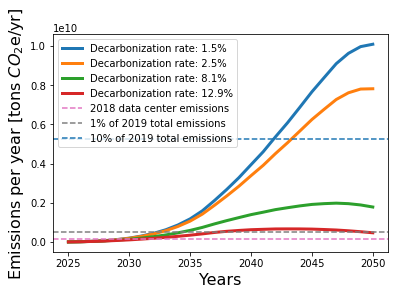

In [33]:
# sweep over different decarbonization rates
plt.figure()
for c in CI_annual_change:
    computing_emissions = []
    projected_carbon_intensity = project_carbon_intensity(years, start_CI, c)
    projected_arch_factor = project_exponential_growth(years, doubling_years_arch, start_arch_mean) 
    projected_hardware_efficiency_ratio_eta = project_hardware_efficiency_ratio(years, 2.81, start_eta)
    # compute emissions for these scenarios
    computing_emissions = simulate_emissions_new_hardware_new_cars(years, car_lifetime, projected_sales_per_year_market_share_95_at_2050, projected_base_tasks, projected_AVs_market_share_95_at_2050, projected_time_driven, projected_carbon_intensity, projected_arch_factor,projected_cameras,projected_throughput,projected_hardware_efficiency_ratio_eta,data_filepath,max_workload_growth_factor,max_sim_computer_power,batt_eff)
    plt.plot(years, np.asarray(computing_emissions), label = "Decarbonization rate: " + str(-100*c)+ "%", linewidth=3)
plt.axhline(y=datacenter_ghg, linestyle='--', color="C6", label = "2018 data center emissions")
plt.axhline(y=one_percent_current_ghg, linestyle='--', color=graycolor, label = "1% of 2019 total emissions")
plt.axhline(y=10*one_percent_current_ghg, linestyle='--', color=bluecolor, label = "10% of 2019 total emissions")
plt.xlabel("Years", fontsize=16)
plt.ylabel("Emissions per year [tons $CO_2$e/yr]", fontsize=16)
plt.legend()
plt.show()

We plot the emissions for different workload doubling trends given the variables set above and the high adoption scenario -- a slower rate of workload growth reduces the emissions from computing. 

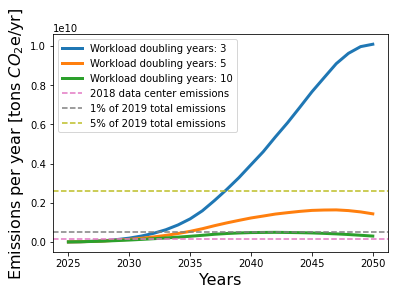

In [34]:
# sweep over different workload growth rates
plt.figure()
for a in doubling_years_arch_sweep:
    computing_emissions = []
    projected_carbon_intensity = project_carbon_intensity(years, start_CI, -0.015)
    projected_arch_factor = project_exponential_growth(years, a, start_arch_mean)
    projected_hardware_efficiency_ratio_eta = project_hardware_efficiency_ratio(years, 2.81, start_eta)
    # compute emissions for these scenarios
    computing_emissions = simulate_emissions_new_hardware_new_cars(years, car_lifetime, projected_sales_per_year_market_share_95_at_2050, projected_base_tasks, projected_AVs_market_share_95_at_2050, projected_time_driven, projected_carbon_intensity, projected_arch_factor,projected_cameras,projected_throughput,projected_hardware_efficiency_ratio_eta,data_filepath,max_workload_growth_factor,max_sim_computer_power,batt_eff)
    plt.plot(years, np.asarray(computing_emissions), label = "Workload doubling years: " + str(round(a,1)), linewidth=3)
plt.axhline(y=datacenter_ghg, linestyle='--', color="C6", label = "2018 data center emissions")
plt.axhline(y=one_percent_current_ghg, linestyle='--', color=graycolor, label = "1% of 2019 total emissions")
plt.axhline(y=5*one_percent_current_ghg, linestyle='--', color="C8", label = "5% of 2019 total emissions")
plt.xlabel("Years", fontsize=16)
plt.ylabel("Emissions per year [tons $CO_2$e/yr]", fontsize=16)
plt.legend(loc='upper left', ncol=1)
plt.show()

We plot the emissions for different rates of hardware energy efficiency increasing given the variables set above and the high adoption scenario -- a faster rate of hardware energy efficiency reduces the emissions from computing.

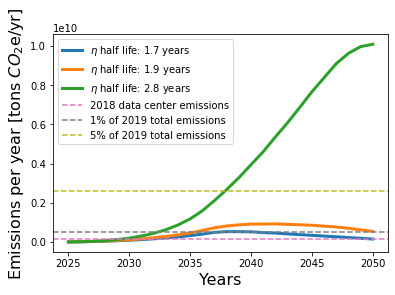

In [35]:
# sweep over different hardware energy efficiency doubling rates
plt.figure()
for counter, r in enumerate([1.66,1.88,2.81]): 
    computing_emissions = []
    projected_carbon_intensity = project_carbon_intensity(years, start_CI, -0.015)
    projected_arch_factor = project_exponential_growth(years, doubling_years_arch, start_arch_mean)
    projected_hardware_efficiency_ratio_eta = project_hardware_efficiency_ratio(years, r, start_eta)
    # compute emissions for these scenarios
    computing_emissions = simulate_emissions_new_hardware_new_cars(years, car_lifetime, projected_sales_per_year_market_share_95_at_2050, projected_base_tasks, projected_AVs_market_share_95_at_2050, projected_time_driven, projected_carbon_intensity, projected_arch_factor,projected_cameras,projected_throughput,projected_hardware_efficiency_ratio_eta,data_filepath,max_workload_growth_factor,max_sim_computer_power,batt_eff)
    plt.plot(years, np.asarray(computing_emissions), label = "$\eta$ half life: " + str(round(r,1))+ " years", linewidth=3)
plt.axhline(y=datacenter_ghg, linestyle='--', color="C6", label = "2018 data center emissions")
plt.axhline(y=one_percent_current_ghg, linestyle='--', color=graycolor, label = "1% of 2019 total emissions")
plt.axhline(y=5*one_percent_current_ghg, linestyle='--', color="C8", label = "5% of 2019 total emissions")
plt.xlabel("Years", fontsize=16)
plt.ylabel("Emissions per year [tons $CO_2$e/yr]", fontsize=16)
plt.legend(loc='upper left', ncol=1)
plt.show()

We plot the emissions for different limits on workload growth over a vehicle's lifetime given the variables set above and the high adoption scenario -- limiting the workload growth over the vehicle's lifetime reduces emissions from computing.

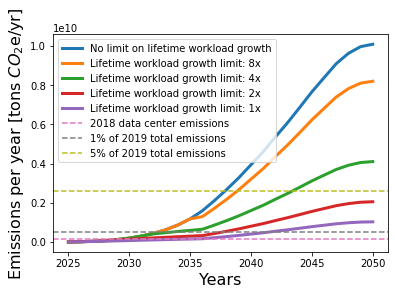

In [36]:
# sweep over different limits on workload growth rate over a vehicle's lifetime
plt.figure()
for counter, max_a in enumerate([np.inf, 8, 4, 2, 1]): 
    computing_emissions = []
    projected_carbon_intensity = project_carbon_intensity(years, start_CI, -0.015)
    projected_arch_factor = project_exponential_growth(years, doubling_years_arch, start_arch_mean)
    projected_hardware_efficiency_ratio_eta = project_hardware_efficiency_ratio(years, 2.81, start_eta)
    # compute emissions for these scenarios
    computing_emissions = simulate_emissions_new_hardware_new_cars(years, car_lifetime, projected_sales_per_year_market_share_95_at_2050, projected_base_tasks, projected_AVs_market_share_95_at_2050, projected_time_driven, projected_carbon_intensity, projected_arch_factor,projected_cameras,projected_throughput,projected_hardware_efficiency_ratio_eta,data_filepath,max_a,max_sim_computer_power,batt_eff)
    if max_a == np.inf:
        # make label for unlimited workload growth rate case 
        plt.plot(years, np.asarray(computing_emissions), label = "No limit on lifetime workload growth", linewidth=3)
    else:
        plt.plot(years, np.asarray(computing_emissions), label = "Lifetime workload growth limit: " + str(max_a)+ "x", linewidth=3)
plt.axhline(y=datacenter_ghg, linestyle='--', color="C6", label = "2018 data center emissions")
plt.axhline(y=one_percent_current_ghg, linestyle='--', color=graycolor, label = "1% of 2019 total emissions")
plt.axhline(y=5*one_percent_current_ghg, linestyle='--', color="C8", label = "5% of 2019 total emissions")
plt.xlabel("Years", fontsize=16)
plt.ylabel("Emissions per year [tons $CO_2$e/yr]", fontsize=16)
plt.legend(loc='upper left', ncol=1)
plt.show()

We plot the emissions for different limits on maximum simulated computer power given the variables set above and the high adoption scenario -- limiting the maximum simulated computer power reduces emissions from computing and avoids illustrating high emissions scenarios that are unlikely given battery capacity and impacts on range.

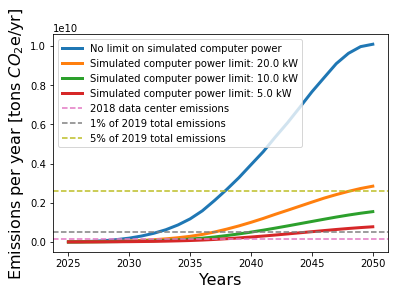

In [37]:
# sweep over different limits on maximum simulated computer power
plt.figure()
for counter, max_sim_p in enumerate([np.inf, 20000, 10000, 5000]): 
    computing_emissions = []
    projected_carbon_intensity = project_carbon_intensity(years, start_CI, -0.015)
    projected_arch_factor = project_exponential_growth(years, doubling_years_arch, start_arch_mean)
    projected_hardware_efficiency_ratio_eta = project_hardware_efficiency_ratio(years, 2.81, start_eta)
    # compute emissions for these scenarios
    computing_emissions = simulate_emissions_new_hardware_new_cars(years, car_lifetime, projected_sales_per_year_market_share_95_at_2050, projected_base_tasks, projected_AVs_market_share_95_at_2050, projected_time_driven, projected_carbon_intensity, projected_arch_factor,projected_cameras,projected_throughput,projected_hardware_efficiency_ratio_eta,data_filepath,max_workload_growth_factor,max_sim_p,batt_eff)
    if max_sim_p == np.inf:
        # make label for unlimited simulated computer power case 
        plt.plot(years, np.asarray(computing_emissions), label = "No limit on simulated computer power", linewidth=3)
    else:
        plt.plot(years, np.asarray(computing_emissions), label = "Simulated computer power limit: " + str(max_sim_p/1000)+ " kW", linewidth=3)
plt.axhline(y=datacenter_ghg, linestyle='--', color="C6", label = "2018 data center emissions")
plt.axhline(y=one_percent_current_ghg, linestyle='--', color=graycolor, label = "1% of 2019 total emissions")
plt.axhline(y=5*one_percent_current_ghg, linestyle='--', color="C8", label = "5% of 2019 total emissions")
plt.xlabel("Years", fontsize=16)
plt.ylabel("Emissions per year [tons $CO_2$e/yr]", fontsize=16)
plt.legend(loc='upper left', ncol=1)
plt.show()

We also compute emissions from 2025-2050 given a medium adoption scenario (95% market share by 2075) over different hardware energy efficiency doubling times. 

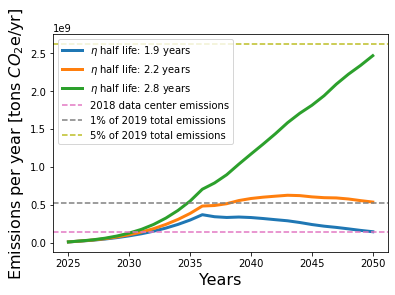

In [38]:
# sweep over different hardware energy efficiency doubling rates for medium adoption scenario
for counter,r in enumerate([1.92, 2.24, 2.81]):
    computing_emissions = []
    projected_carbon_intensity = project_carbon_intensity(years, start_CI, -0.015)
    projected_arch_factor = project_exponential_growth(years, doubling_years_arch, start_arch_mean)
    projected_hardware_efficiency_ratio_eta = project_hardware_efficiency_ratio(years, r, start_eta)
    # compute emissions for these scenarios
    computing_emissions = simulate_emissions_new_hardware_new_cars(years, car_lifetime, projected_sales_per_year_market_share_95_at_2075, projected_base_tasks, projected_AVs_market_share_95_at_2075, projected_time_driven, projected_carbon_intensity, projected_arch_factor,projected_cameras,projected_throughput,projected_hardware_efficiency_ratio_eta,data_filepath,max_workload_growth_factor,max_sim_computer_power,batt_eff)
    plt.plot(years, np.asarray(computing_emissions), label = "$\eta$ half life: " + str(round(r,1))+ " years", linewidth=3)
plt.axhline(y=datacenter_ghg, linestyle='--', color="C6", label = "2018 data center emissions")
plt.axhline(y=one_percent_current_ghg, linestyle='--', color=graycolor, label = "1% of 2019 total emissions")
plt.axhline(y=5*one_percent_current_ghg, linestyle='--', color="C8", label = "5% of 2019 total emissions")
plt.xlabel("Years", fontsize=16)
plt.ylabel("Emissions per year [tons $CO_2$e/yr]", fontsize=16)
plt.legend(loc='upper left', ncol=1)
plt.show()

Finally, we calculate the doubling years of hardware energy efficiency needed if emissions are equal to 2018 data center emissions or 1% of 2019 total emissions for the high adoption and moderate adoption scenarios numerically as follows. 

In [39]:
# numerically find intersection of hardware energy efficiency half life and baseline emissions 
# high adoption scenario
print("High adoption scenario (95% market share by 2050): ")
datacenter_flag = False # initialize to false (data center soln not found yet)
for r in np.arange(1.0,5,0.01):
    computing_emissions = []
    projected_carbon_intensity = project_carbon_intensity(years, start_CI, -0.015)
    projected_arch_factor = project_exponential_growth(years, doubling_years_arch, start_arch_mean)
    projected_hardware_efficiency_ratio_eta = project_hardware_efficiency_ratio(years, r, start_eta)
    computing_emissions = simulate_emissions_new_hardware_new_cars(years, car_lifetime, projected_sales_per_year_market_share_95_at_2050, projected_base_tasks, projected_AVs_market_share_95_at_2050, projected_time_driven, projected_carbon_intensity, projected_arch_factor,projected_cameras,projected_throughput,projected_hardware_efficiency_ratio_eta,data_filepath,max_workload_growth_factor,max_sim_computer_power,batt_eff)
    if (float(computing_emissions[-1]) > datacenter_ghg) and (datacenter_flag == False):
        datacenter_flag = True
        print("   Hardware energy efficiency doubling years: " + str(round(r,2))+ " years for 2050 emissions to equal data center")
    if float(computing_emissions[-1]) > one_percent_current_ghg:
        print("   Hardware energy efficiency doubling years: " + str(round(r,2))+ " years for 2050 emissions to equal 1% 2019 emissions")
        break
# moderate adoption scenario
print("Moderate adoption scenario (95% market share by 2075): ")
datacenter_flag = False # initialize to false (data center soln not found yet)
for r in np.arange(1.0,5,0.01):
    computing_emissions = []
    projected_carbon_intensity = project_carbon_intensity(years, start_CI, -0.015)
    projected_arch_factor = project_exponential_growth(years, doubling_years_arch, start_arch_mean)
    projected_hardware_efficiency_ratio_eta = project_hardware_efficiency_ratio(years, r, start_eta)
    computing_emissions = simulate_emissions_new_hardware_new_cars(years, car_lifetime, projected_sales_per_year_market_share_95_at_2075, projected_base_tasks, projected_AVs_market_share_95_at_2075, projected_time_driven, projected_carbon_intensity, projected_arch_factor,projected_cameras,projected_throughput,projected_hardware_efficiency_ratio_eta,data_filepath,max_workload_growth_factor,max_sim_computer_power,batt_eff)
    if (float(computing_emissions[-1]) > datacenter_ghg) and (datacenter_flag == False):
        datacenter_flag = True
        print("   Hardware energy efficiency doubling years: " + str(round(r,2))+ " years for 2050 emissions to equal data center")
    if float(computing_emissions[-1]) > one_percent_current_ghg:
        print("   Hardware energy efficiency doubling years: " + str(round(r,2))+ " years for 2050 emissions to equal 1% 2019 emissions")
        break

High adoption scenario (95% market share by 2050): 
   Hardware energy efficiency doubling years: 1.66 years for 2050 emissions to equal data center
   Hardware energy efficiency doubling years: 1.88 years for 2050 emissions to equal 1% 2019 emissions
Moderate adoption scenario (95% market share by 2075): 
   Hardware energy efficiency doubling years: 1.92 years for 2050 emissions to equal data center
   Hardware energy efficiency doubling years: 2.24 years for 2050 emissions to equal 1% 2019 emissions
